In [1]:
# Example from https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb

import torch
from torch import nn, optim

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv('data/AAPL_data.csv')
df.dropna()

df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index=df['Date']
data = df.sort_index(ascending=True, axis=0)
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

df = add_all_ta_features(
    df, high="High", low="Low", open="Open", close="Close", volume="Volume")

print(f'Number of Entries: {len(df)}')
df.head()

Number of Entries: 1260


/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Date,High,Low,Open,Close,Volume,Adj Close,Year,Month,Week,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-28,2017-04-28,36.075001,35.817501,36.022499,35.912498,83441600.0,33.907143,2017,4,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.906234,NaN,0.000000
2017-05-01,2017-05-01,36.799999,36.240002,36.275002,36.645000,134411600.0,34.598736,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.039685,2.019162,2.039685
2017-05-02,2017-05-02,37.022499,36.709999,36.884998,36.877499,181408800.0,34.818253,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.634461,0.632457,2.687087
2017-05-03,2017-05-03,36.872501,36.067501,36.397499,36.764999,182788000.0,34.712040,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.305062,-0.305528,2.373828
2017-05-04,2017-05-04,36.785000,36.452499,36.630001,36.632500,93487600.0,34.586937,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.360396,-0.361047,2.004876


/Users/alejandrosaenz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


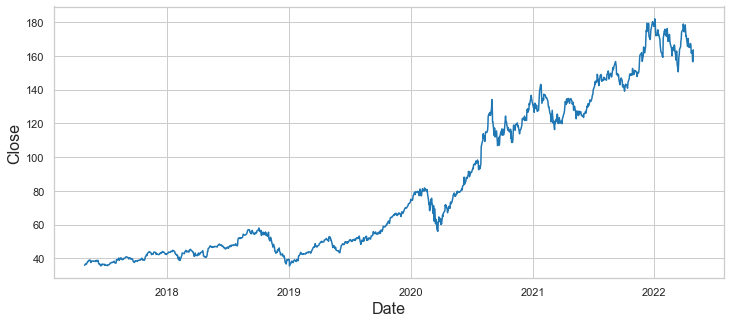

In [4]:
plt.figure(figsize=[12., 5.])
ax = sns.lineplot(df.index, df.Close, data=df)
#ax.set_xlabel('months');

In [5]:
# Select time frame
df = df[df['Date'] >= '2022-01-01']

# Create y variable
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

# Select features 
selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']

reduced_df = df[selected_features + basic_features]



In [6]:
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [11]:
# Convert data to float32 for PyTorch
reduced_df = reduced_df.astype(np.float32)

# I'm going to convert this to train and test instead of train and valid.
# Train will include validation set through cross validation.

# Split training and validation data
split = int(0.8 * len(df))
x_train = reduced_df[:split].to_numpy() #.reshape(-1, 1)
x_test = reduced_df[split:].to_numpy() #.reshape(-1, 1)

y_train = y[:split].reshape(-1, 1)
y_test = y[split:].reshape(-1, 1)

# scale data: MOVED THIS TO HAPPEN WITHIN CROSS VALIDATION

# t_scaler = MinMaxScaler(feature_range=(-1, 1))
# v_scaler = MinMaxScaler(feature_range=(-1, 1))
# x_train = t_scaler.fit_transform(x_train)
# x_test = v_scaler.fit_transform(x_test)

# convert training data to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [12]:
# Create training and test set:
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [13]:
def get_batches(data, window):
    """
    Takes data with shape (n_samples, n_features) and creates mini-batches
    with shape (1, window). 
    """
    x_data, y_data = data
    L = len(x_data)
    for i in range(L - window):
        x_sequence = x_data[i:i + window]
        y_sequence = y_data[i:i + window]
        yield x_sequence, y_sequence

In [14]:
class stocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
   
        out, hs = self.lstm(x, hs)           # out.shape = (batch_size, seq_len, hidden_size)
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc(out)
        
        return out, hs

In [15]:
input_size = x_train.size()[1]  # 21 in current implementation
hidden_size = 100
num_layers = 1
output_size = 1

model = stocksLSTM(input_size, hidden_size, num_layers, output_size)

In [17]:
def train(model, epochs, train_set, valid_data=None, lr=0.001, print_every=100):

    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        
        hs = None
        t_loss = 0
        for x, y in get_batches(train_set, 12):

            opt.zero_grad()
            
            # Create batch_size dimension
            x = x.unsqueeze(0)
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])
            
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            
        if valid_data is not None:
                model.eval()
                val_x, val_y = valid_data
                val_x = val_x.unsqueeze(0)
                preds, _ = model(val_x, hs)
                v_loss = criterion(preds, val_y)
                valid_loss.append(v_loss.item())
                
                model.train()
            
        train_loss.append(np.mean(t_loss))
            
            
        if e % print_every == 0:
            print(f'Epoch {e}:\nTraining Loss: {train_loss[-1]}')
            if valid_data is not None:
                print(f'Validation Loss: {valid_loss[-1]}')
        
    return train_loss, valid_loss
    
#     plt.figure(figsize=[8., 6.])
#     plt.plot(train_loss, label='Training Loss')
#     plt.plot(valid_loss, label='Validation Loss')
#     plt.title('Loss vs Epochs')
#     plt.xlabel('Epochs')
#     plt.legend()
#     plt.show()

In [18]:
def train_cross_valid(model, epochs, lr, training_data):
    train_losses = []
    valid_losses = []
    X_train, y_train = training_data
    for train_index, validation_index in tscv.split(X_train):
        # print("TRAIN:", train_index, "VALIDATION:", validation_index)
        # Split training and validation data
#         split = int(0.8 * len(df))
#         x_train = X_train[train_index].to_numpy() #.reshape(-1, 1)
#         x_valid = X_train[validation_index].to_numpy() #.reshape(-1, 1)
        x_train_fold = X_train[train_index]
        x_valid_fold = X_train[validation_index]

        y_train_fold = y[train_index].reshape(-1, 1)
        y_valid_fold = y[validation_index].reshape(-1, 1)

        # scale data
#         t_scaler = MinMaxScaler(feature_range=(-1, 1))
#         v_scaler = MinMaxScaler(feature_range=(-1, 1))
        t_scaler = MinMaxScaler()
        x_train_fold = t_scaler.fit_transform(x_train_fold)
        x_valid_fold = t_scaler.transform(x_valid_fold)

        # convert training data to tensor
        x_train_fold = torch.tensor(x_train_fold, dtype=torch.float32)
        x_valid_fold = torch.tensor(x_valid_fold, dtype=torch.float32)

        y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32)
        y_valid_fold = torch.tensor(y_valid_fold, dtype=torch.float32)

        # Create training and validation set:
        train_data_fold = (x_train_fold, y_train_fold)
        valid_data_fold = (x_valid_fold, y_valid_fold)
        
        train_loss, valid_loss = train(model, epochs, train_data_fold, valid_data=valid_data_fold, lr=lr)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses

In [19]:
# Explore what's going on with TimeSeriesSplit

X_train, y_train = train_data
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16 17 18 19 20 21 22 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [24 25 26 27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40 41 42 43]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] TEST: [44 45 46 47 48 49 50 51 52 53]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53] TEST: [54 55 56 57 58 59 60 61 62 63]


In [20]:
# train(model, 500, train_data, lr=0.0005, valid_data=valid_data)
train_losses, valid_losses = train_cross_valid(model, 200, 0.0005, train_data)

Epoch 0:
Training Loss: 2.1083877086639404
Validation Loss: 1.1209774017333984
Epoch 100:
Training Loss: 0.5483289957046509
Validation Loss: 0.9396907687187195
Epoch 0:
Training Loss: 15.470956375356764
Validation Loss: 2.112244129180908
Epoch 100:
Training Loss: 4.328111797571182
Validation Loss: 1.7775423526763916
Epoch 0:
Training Loss: 10.044213138986379
Validation Loss: 0.9017232060432434
Epoch 100:
Training Loss: 1.2911991057917476
Validation Loss: 1.2682536840438843
Epoch 0:
Training Loss: 8.058797676116228
Validation Loss: 1.1177449226379395
Epoch 100:
Training Loss: 0.6181651565711945
Validation Loss: 1.5350414514541626
Epoch 0:
Training Loss: 10.663031568750739
Validation Loss: 1.8852519989013672
Epoch 100:
Training Loss: 0.7043680313508958
Validation Loss: 1.9552583694458008


In [21]:
valid_losses

[[1.1209774017333984,
  1.0740149021148682,
  1.0323463678359985,
  0.9964723587036133,
  0.9669238924980164,
  0.9438545107841492,
  0.9268706440925598,
  0.9150857925415039,
  0.9073152542114258,
  0.9022672772407532,
  0.8986468315124512,
  0.8952061533927917,
  0.890803337097168,
  0.8845208883285522,
  0.8758923411369324,
  0.8653091192245483,
  0.8547154664993286,
  0.848648190498352,
  0.8547686338424683,
  0.8804012537002563,
  0.9251812696456909,
  0.9832595586776733,
  1.0521676540374756,
  1.1298422813415527,
  1.2057801485061646,
  1.2643203735351562,
  1.2951009273529053,
  1.2929110527038574,
  1.254786729812622,
  1.187417984008789,
  1.1165155172348022,
  1.0713286399841309,
  1.0548230409622192,
  1.0488572120666504,
  1.0401437282562256,
  1.027851939201355,
  1.0178364515304565,
  1.0161033868789673,
  1.023871660232544,
  1.0370771884918213,
  1.050513505935669,
  1.0619826316833496,
  1.0730314254760742,
  1.0866156816482544,
  1.1039257049560547,
  1.1228959560394

In [14]:
# get predictions on training set
hs = None
train_preds, hs = model(x_train.unsqueeze(0), hs)
train_preds = t_scaler.inverse_transform(train_preds.detach())

# Get predictions on validation data
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = v_scaler.inverse_transform(valid_preds.detach())

ValueError: non-broadcastable output operand with shape (67,1) doesn't match the broadcast shape (67,21)

In [15]:
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = valid_preds.reshape(-1)
valid_preds = np.where(valid_preds > 0, 1, -1)

y_valid_np = y_valid.numpy().reshape(-1)

correct_preds = np.where(valid_preds == y_valid_np, 1, 0)
valid_acc = sum(correct_preds) / len(correct_preds)
valid_acc



0.5882352941176471

In [16]:
train_time = data.index[:split]
valid_time = data.index[split:]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

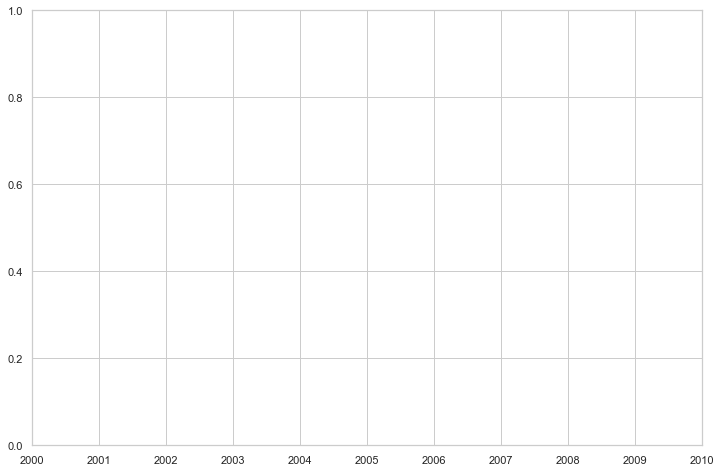

In [17]:
plt.plot(train_time, train_preds.squeeze(), 'r--', label='Training Predictions', )
plt.plot(valid_time, valid_preds.squeeze(), 'g--', label='Validation Predictions')
#plt.plot(reduced_df.index, reduced_df.y.detach().numpy(), label='Actual')
#plt.xticks(np.arange(0,145,12))
plt.legend()